<a href="https://colab.research.google.com/github/juanmarinom/RobotJardinero/blob/Vision/TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Versión 2.0

Una vez probados los resultados con una red neuronal entrenada desde cero, se va a tratar de mejorar sensiblemente los resultados de la clasificación. El dataset del que se dispone es bastante pequeño para este tipo de entrenamientos (alrededor de 300 imágenes por clase), por lo que se hará uso de la técnica *Transfer Learning*.

Primero, se instalan las dependecias necesarias y se importan los datos:


In [4]:
!pip install tensorflow
!pip install keras==2.3.1


In [5]:
from google.colab import drive
drive.mount('/content/drive/')
!unzip '/content/drive/My Drive/flowers.zip' -d '/content/flower_data'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Archive:  /content/drive/My Drive/flowers.zip
replace /content/flower_data/tulips/100930342_92e8746431_n.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/flower_data/tulips/10094729603_eeca3f2cb6.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/flower_data/tulips/10094731133_94a942463c.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


Después, se importa el VGG16, una red neuronal convolucional propuesta por K. Simonyan y A. Zisserman. Este modelo consigue un 92.7% de precisión en ImageNet, un dataset con más de 14 millones de imágenes pertenecientes a 1000 clases.

In [10]:
import numpy as np
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D, Dropout
from keras import optimizers

train_datagen=ImageDataGenerator(rescale=1./255.,
                                 #rotation_range=40,
                                 #width_shift_range=0.2,
                                 #height_shift_range=0.2,
                                 #shear_range=0.2,
                                 #zoom_range=0.2,
                                 #horizontal_flip=True,
                                 #fill_mode="nearest",
                                 validation_split=0.2,
                                 preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory('/content/flower_data',
                                                    target_size=(150,150), #to meet VGG requirements
                                                    color_mode='rgb',
                                                    batch_size=16,
                                                    class_mode='categorical',
                                                    subset='training')
validation_generator = train_datagen.flow_from_directory('/content/flower_data',
                                                         target_size=(150,150),
                                                         color_mode='rgb',
                                                         batch_size=16,
                                                         class_mode='categorical',
                                                         subset='validation')

#Como base, tomaremos el VGG16, con casi 15 millones de parámetros entrenables
base_model=VGG16(weights="imagenet",
                 include_top=False, 
                 input_shape=(150,150,3))


#Se añade una última capa (Fully Connected), que será la que se entrenará con las imágenes
modeloPropio = Sequential()
modeloPropio.add(base_model)

modeloPropio.add(Flatten())
modeloPropio.add(Dense(units=64,activation="relu"))
#modeloPropio.add(Dropout(0.5))
modeloPropio.add(Dense(units=32,activation="relu"))
modeloPropio.add(Dense(units=16,activation="relu"))
modeloPropio.add(Dense(5, activation="softmax"))

#Establecemos que el modelo de VGG16 ya está entrenado, por lo que se deshabilita como parte del entrenamiento
base_model.trainable=False

#custom optimizer
sgd = optimizers.SGD(lr=0.01, decay=1e-3, momentum=0.9, nesterov=True)

modeloPropio.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

#step size
step_size_train = train_generator.n//train_generator.batch_size
step_size_valid = validation_generator.n//validation_generator.batch_size



#fit the model
history = modeloPropio.fit_generator(train_generator,
                                     steps_per_epoch=step_size_train,
                                     epochs=30,
                                     validation_data=validation_generator,
                                     validation_steps=step_size_valid,
                                     shuffle = True)

Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.
Epoch 1/30
183/183 [==============================] - 14s 78ms/step - loss: 0.9620 - accuracy: 0.6312 - val_loss: 1.0868 - val_accuracy: 0.7389
Epoch 2/30
183/183 [==============================] - 14s 79ms/step - loss: 0.5034 - accuracy: 0.8149 - val_loss: 0.3909 - val_accuracy: 0.7720
Epoch 3/30
183/183 [==============================] - 14s 79ms/step - loss: 0.3516 - accuracy: 0.8720 - val_loss: 0.2153 - val_accuracy: 0.8042
Epoch 4/30
183/183 [==============================] - 14s 79ms/step - loss: 0.2081 - accuracy: 0.9264 - val_loss: 0.5097 - val_accuracy: 0.7902
Epoch 5/30
183/183 [==============================] - 14s 79ms/step - loss: 0.1341 - accuracy: 0.9552 - val_loss: 0.2107 - val_accuracy: 0.8140
Epoch 6/30
183/183 [==============================] - 14s 78ms/step - loss: 0.0785 - accuracy: 0.9743 - val_loss: 0.8305 - val_accuracy: 0.8014
Epoch 7/30
183/183 [==============================] -

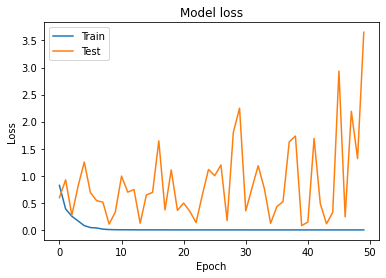

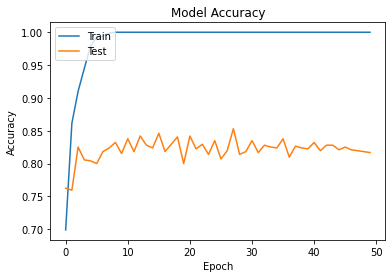

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot training & validation accuracy values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
import os
# Guardar el Modelo
modeloPropio.save('/content/drive/My Drive/TF_85.h5')
